In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
from torchsummary import summary
from IPython.display import HTML

# Question 1:
### [Total marks: 2.5] Consider the dataset below (1.1). Find MLE estimate for parameters of a neural network for regression with Gaussian Homoskedastic noise, where noise variance has a fixed value = 0.0025. Your model summary should match with (1.2). Animate the MLE fit on the data along with the 95% noise variance intervals [2 marks]. 

In [2]:
np.random.seed(0)
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, 0.05, 100)
y_values = np.sin(2 * np.pi * x_values) + noise
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)

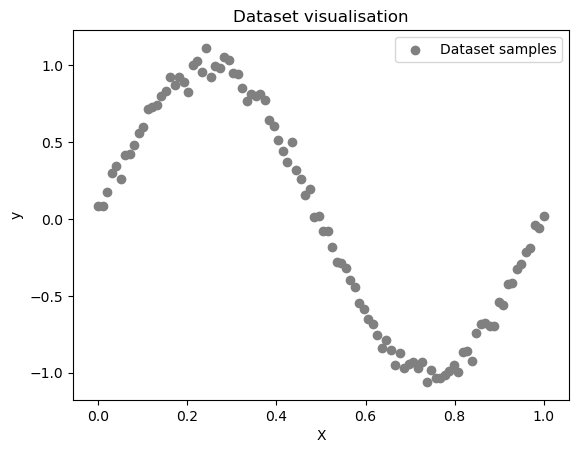

In [3]:
plt.scatter(x_values, y_values, label='Data with Noise', color='gray');
plt.title("Dataset visualisation")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(['Dataset samples'])

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_tensor = torch.tensor(x_values, dtype=torch.float32,device=device).unsqueeze(1)
y_tensor = torch.tensor(y_values, dtype=torch.float32,device=device).unsqueeze(1)

In [39]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(1, 10)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(10, 10)
        self.selu = nn.SELU()
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.selu(x)
        x = self.linear3(x)
        return x

model = RegressionModel()
model.to(device)
summary(model,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
              GELU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              SELU-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
Total params: 141
Trainable params: 141
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [40]:
def nll():
    mu = model(X_tensor)
#     print(mu)
    sigma = torch.tensor(0.05,device=device)
    dist = torch.distributions.normal.Normal(mu,sigma)
    return -dist.log_prob(y_tensor).sum()

In [42]:
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = nll()
#     print(out)
    
    out.backward()
    optimizer.step()
    out_list.append(out.cpu().detach().numpy())

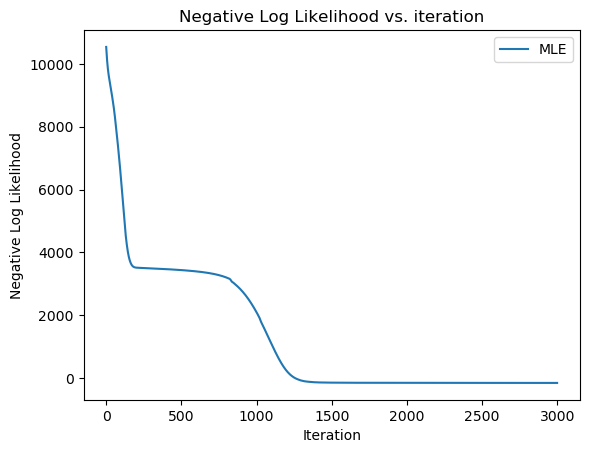

In [66]:
plt.plot(out_list)
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')
plt.legend(['MLE'])
plt.title('Negative Log Likelihood vs. iteration');

In [48]:
with torch.no_grad():
    y_pred = model(X_tensor)
    y_pred = y_pred.cpu().numpy().flatten()

In [49]:
# Define your true function
def true_function(x):
    return np.sin(2 * np.pi * x)

# Create data and Gaussian PDFs
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, np.sqrt(0.0025), 100)
y_values = true_function(x_values) + noise

def animate(frame):
    # plt.clf()
    if frame == 0:
        plt.scatter(x_values,true_function(x_values), color='tab:blue')
    elif frame == 1:
        plt.scatter(x_values,true_function(x_values), color='tab:blue')
        plt.scatter(x_values, y_values, label='Data with Noise', color='tab:gray')
    elif frame == 2:
        plt.scatter(x_values,true_function(x_values), label='True Function',color='tab:blue')
        plt.scatter(x_values, y_values, color='gray')         
        plt.plot(x_values, y_pred, 'r', label='MLE Fit')
        plt.fill_between(x_values, y_pred - 2 * np.sqrt(0.0025), y_pred + 2 * np.sqrt(0.0025), color='r', alpha=0.3, label='95% Interval')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


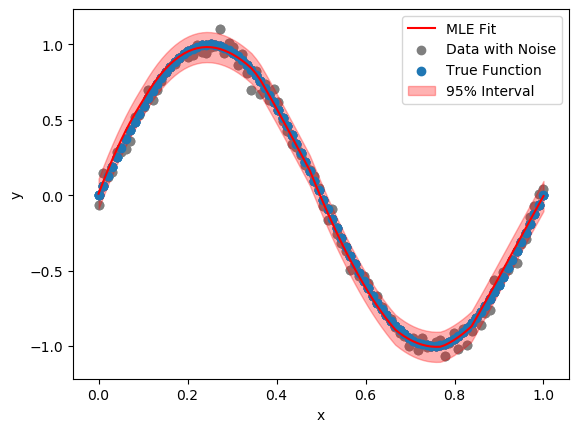

In [50]:
fig = plt.figure()
fig.set_facecolor('white')
anim = FuncAnimation(fig, animate, frames=3, interval=2000, repeat=True)
HTML(anim.to_jshtml())

### What is the effect of varying the noise variance (only in model, not for regenerating the data) on the MLE fit, show it for 3 different noise variance values? [0.5 mark] Refer to this tutorial for building and training torch.nn models. Use FuncAnimation from matplotlib or Celluloid for animation.

In [52]:
def nll_with_var(var):
    mu = model(X_tensor)
#     print(mu)
    sigma = torch.tensor(var,device=device)
    dist = torch.distributions.normal.Normal(mu,sigma)
    return -dist.log_prob(y_tensor).sum()

In [60]:
y_pred_list = []
for var in [0.0025,500.0,5.0]:
    # Gradient descent loop
    n_epochs = 1000
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch_itr in range(n_epochs):
        optimizer.zero_grad()
        out = nll_with_var(var)
    #     print(out)

        out.backward()
        optimizer.step()
        
    with torch.no_grad():
        y_pred = model(X_tensor)
        y_pred = y_pred.cpu().numpy().flatten()
        y_pred_list.append(y_pred)



Text(0, 0.5, 'y')

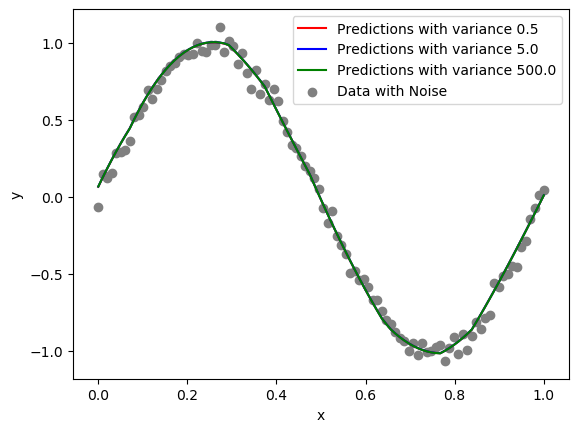

In [64]:
plt.scatter(x_values, y_values, label='Data with Noise', color='gray')
plt.plot(x_values, y_pred_list[0], label='Predictions with variance 0.5', color='red')
plt.plot(x_values, y_pred_list[1], label='Predictions with variance 5.0 ', color='blue')
plt.plot(x_values, y_pred_list[2], label='Predictions with variance 500.0', color='green')
plt.fill_between(x_values, y_pred_list[0] - 2 * np.sqrt(0.0025), y_pred + 2 * np.sqrt(0.0025), color='r', alpha=0.3, label='95% Interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')


Conclusion: The MLE is an estimate of the mean of a normal distribution which stays unaffected by change in variance.

# Question 2:
### [Total marks: 1.5] You toss a coin 10 times and the result turns out to be: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0]. Find the MAP estimate for probability of heads if: Prior is Beta distribution with parameters (alpha=2, beta=3):

In [70]:
y = [1.0, 0, 0, 1.0, 1.0, 0, 1.0, 0, 0, 0]
alpha = 2
beta = 3
y = torch.tensor(y)

### i)

### a) Calculate the answer analytically using the closed form MAP estimate [0.5 mark]

Given data:
Number of heads $y_i = 4 $
Total no of tosses $(N)  = 10 $
$$
prior = p(\theta) = \frac{B(\alpha, \beta)}{\theta^{\alpha - 1} \cdot (1 - \theta)^{\beta - 1}}
$$
$\alpha = 2 , \beta = 3$

$$\theta_{\text{MAP}} = \arg\max_{\theta} P(\theta | D) = {P(D|\theta) \cdot P(\theta)}$$

$$\log P(\theta | D) = \sum_{i=0}^{N} \left( \log P(y_i|\theta) + \log P(\theta) \right)$$

$$\log P(\theta | D) = \sum_{i=0}^{N} \left( y_i\log\theta + (1 - y_i) \log(1-\theta) + (\alpha - 1)\log(\theta) + (\beta - 1)\log(1 - \theta) \right)$$

$$\frac{d}{d\theta} \left( \log P(\theta | D) \right) = \left( \frac{ \sum_{i=0}^{N}y_i}{\theta} - \frac{ \sum_{i=0}^{N}1 - y_i}{1 - \theta} + \frac{\alpha - 1}{\theta} - \frac{\beta - 1}{1 - \theta} \right) = 0$$

$$(1 - \theta) \sum_{i=0}^{N} y_i -  \theta \sum_{i=0}^{N} (1 - y_i)\ + (\alpha - 1) (1 - \theta) - (\beta - 1) \theta = 0
$$


$$\sum_{i=0}^{N} y_i + \alpha - 1 - \theta(N + \alpha +\beta -2) = 0$$

$$\theta_{\text{MAP}} = \frac{\sum_{i=0}^{N} y_i + \alpha - 1}{(N + \alpha +\beta -2)}$$

$$\theta_{\text{MAP}} = \frac{ 4 + 2 - 1}{(10 + 2 + 3 -2)}$$



In [71]:
analytical_theta_map = (sum(y) + alpha -1)/(len(y)+alpha + beta-2)
print("Analytically theta_map estimate for prob of heads is:",analytical_theta_map.detach().numpy()[0])

Analytically theta_map estimate for prob of heads is: tensor(0.3846)


### i)

### b) Find the answer with gradient descent using torch.optim [0.5 mark]

In [73]:
def nll(theta):
    dist = torch.distributions.Bernoulli(theta)
    return -dist.log_prob(y).sum()

def neg_log_prior(theta):
    dist = torch.distributions.beta.Beta(alpha, beta)
    return -dist.log_prob(theta).sum()

def neg_log_joint(theta):
    return nll(theta) + neg_log_prior(theta)

In [74]:
# For Beta prior

theta = torch.tensor([0.5], requires_grad=True)
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.SGD([theta], lr=0.001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = neg_log_joint(theta)
#     print(out,theta)

    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())


In [75]:
print("Estimate of theta_map using SGD for prob of heads is:",theta.detach().numpy()[0])

Estimate of theta_map using SGD for prob of heads is: tensor([0.3846], requires_grad=True)


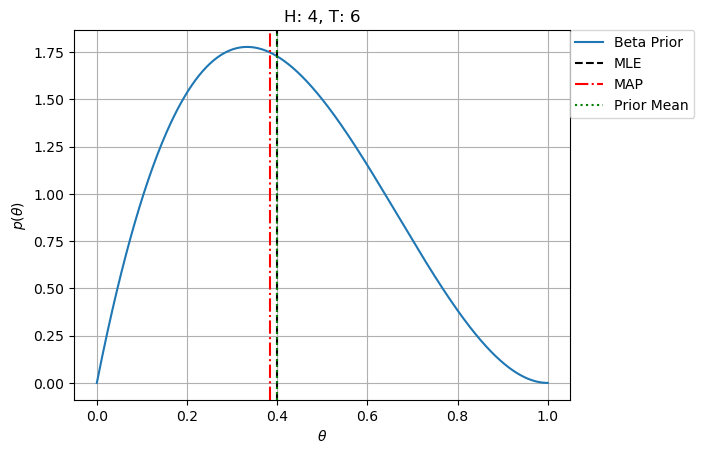

In [84]:
n_1 = 4
n_0 = 6

dist = torch.distributions.Beta(concentration1=alpha, concentration0=beta)
xs = torch.linspace(0, 1, 500)
ys = dist.log_prob(xs).exp()
plt.plot(xs, ys, label="Beta Prior")

sample_size = n_1 + n_0
plt.title(f"H: {n_1}, T: {n_0}")

mle_estimate = n_1 / (sample_size)  # samples.mean()
plt.axvline(mle_estimate, color="k", linestyle="--", label="MLE")

map_estimate = (n_1 + alpha - 1) / (sample_size + alpha + beta - 2)
plt.axvline(map_estimate, color="r", linestyle="-.", label="MAP")

plt.axvline(alpha / (alpha + beta), color="g", linestyle=":", label="Prior Mean")

plt.grid()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)
# plt.savefig("../figures/map/coin_toss_prior_mle_map.pdf", bbox_inches="tight")
plt.show()

### ii) Prior is a Gaussian distribution with mean=0.5 and variance=0.1. Find the answer with gradient descent using torch.optim [0.5 mark]

In [76]:
def nll(theta):
    dist = torch.distributions.Bernoulli(theta)
    return -dist.log_prob(y).sum()

def neg_log_prior(theta):
    dist = torch.distributions.normal.Normal(0.5, np.sqrt(0.1))
    return -dist.log_prob(theta).sum()

def neg_log_joint(theta):
    return nll(theta) + neg_log_prior(theta)

In [77]:
# For Gaussian prior

theta = torch.tensor([0.5], requires_grad=True)
# Gradient descent loop
n_epochs = 1000
optimizer = torch.optim.SGD([theta], lr=0.001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = neg_log_joint(theta)
#     print(out,theta)

    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())

In [87]:
print("Estimate of theta_map with Gaussian prior using SGD for prob of heads is:",theta.detach().numpy()[0])

Estimate of theta_map with Gaussian prior using SGD for prob of heads is: 0.41958424


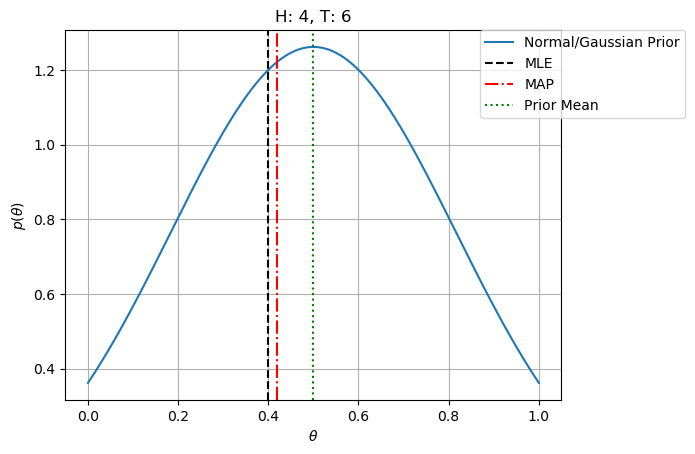

In [85]:
n_1 = 4
n_0 = 6

dist = torch.distributions.normal.Normal(0.5, np.sqrt(0.1))
xs = torch.linspace(0, 1, 500)
ys = dist.log_prob(xs).exp()
plt.plot(xs, ys, label="Normal/Gaussian Prior")

sample_size = n_1 + n_0
plt.title(f"H: {n_1}, T: {n_0}")

mle_estimate = n_1 / (sample_size)  # samples.mean()
plt.axvline(mle_estimate, color="k", linestyle="--", label="MLE")

map_estimate = theta.detach().numpy()
plt.axvline(map_estimate, color="r", linestyle="-.", label="MAP")

plt.axvline(0.5, color="g", linestyle=":", label="Prior Mean")

plt.grid()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)
# plt.savefig("../figures/map/coin_toss_prior_mle_map.pdf", bbox_inches="tight")
plt.show()

# Question 3:
### [Total marks: 2.5] Generate a linear trend dataset with the following code (3.1). Find MAP estimate for slope and intercept:
### Prior is Normal distribution with mean=0 and variance=1 [1 marks]


In [116]:
slope = 3
intercept = 2
N = 100
X = np.linspace(0, 1, N)
noise = np.random.normal(0, 0.05, N)
y = slope * X + intercept + noise

X = torch.tensor(X)
y = torch.tensor(y)

In [117]:
def nll(theta):
    mu = theta[1]* X + theta[0]
    sigma = torch.tensor(1.0)
    dist = torch.distributions.normal.Normal(mu,sigma)
    return -dist.log_prob(y).sum()

def neg_log_prior(theta):
    prior_mean = torch.tensor([0.0,0.0])  # Prior mean for slope and intercept
    prior_std = torch.tensor(
        [1.0, 1.0]
    )  # Prior standard deviation for slope and intercept
    dist = torch.distributions.normal.Normal(prior_mean, prior_std)
    return -dist.log_prob(theta).sum()

def neg_log_joint(theta):
    return nll(theta) + neg_log_prior(theta)

In [118]:
theta = torch.tensor([1.0,1.0], requires_grad=True)
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.SGD([theta], lr=0.001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = neg_log_joint(theta)
#     print(out,theta)
    
    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())

print(theta)

tensor([2.0672, 2.8263], requires_grad=True)


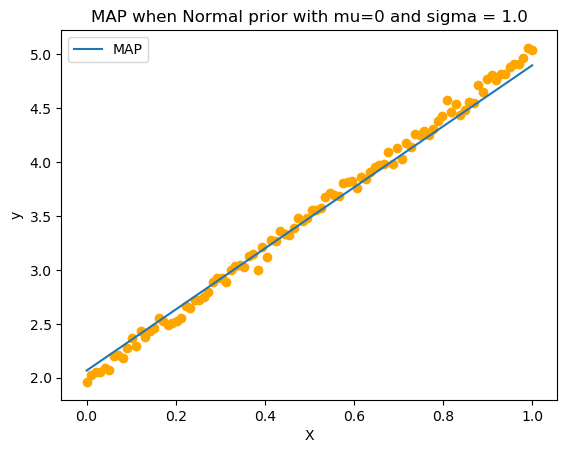

In [119]:
Xt=X.detach().numpy()
thetat = theta.detach().numpy()


plt.scatter(Xt,y,c='orange')
ypoints_map = thetat[1]* Xt + thetat[0]
plt.plot(Xt,ypoints_map)
plt.legend(['MAP'])
plt.xlabel("X")
plt.ylabel("y")
plt.title("MAP when Normal prior with mu=0 and sigma = 1.0")
plt.show()

### Show the effect of varying the size of the dataset on the MAP estimate [0.5 mark]

In [120]:
theta_list = []
for n in [10,20,50,100,1000]:
    slope = 3
    intercept = 2
    X = np.linspace(0, 1, n)
    noise = np.random.normal(0, 0.05, n)
    y = slope * X + intercept + noise

    X = torch.tensor(X)
    y = torch.tensor(y)
    
    theta = torch.tensor([1.0,1.0], requires_grad=True)
    # Gradient descent loop
    n_epochs = 3000
    optimizer = torch.optim.SGD([theta], lr=0.001)
    # out_list = []
    for epoch_itr in range(n_epochs):
        optimizer.zero_grad()
        out = neg_log_joint(theta)
    #     print(out,theta)

        out.backward()
        optimizer.step()
    #     out_list.append(out.detach().numpy())

    theta_list.append(theta)

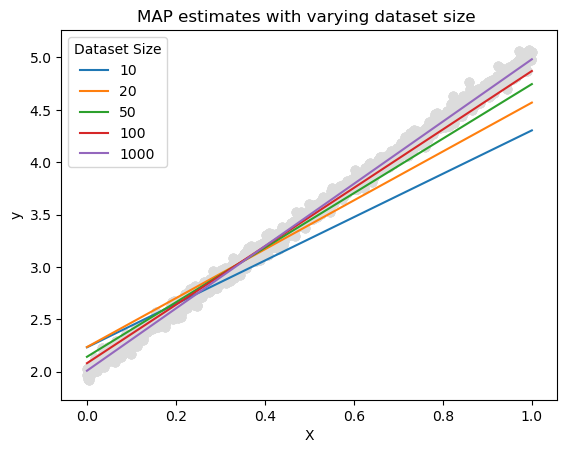

In [121]:
for th in theta_list:
    Xt=X.detach().numpy()
    thetat = th.detach().numpy()


    plt.scatter(Xt,y,c='gainsboro')
    ypoints_map = thetat[1]* Xt + thetat[0]
    
    
    plt.plot(Xt,ypoints_map)
plt.legend(['10','20','50','100','1000'],title = "Dataset Size")
plt.xlabel("X")
plt.ylabel("y")
plt.title("MAP estimates with varying dataset size ")
plt.show()

### Show the effect of varying the prior variance on the MAP estimate [0.5 mark]

In [122]:
def neg_log_prior_var(theta,var):
    prior_mean = torch.tensor([0.0,0.0])  # Prior mean for slope and intercept
    prior_std = torch.tensor(
        [np.sqrt(var), np.sqrt(var)]
    )  # Prior standard deviation for slope and intercept
    dist = torch.distributions.normal.Normal(prior_mean, prior_std)
    return -dist.log_prob(theta).sum()

def neg_log_joint_var(theta,var):
    return nll(theta) + neg_log_prior_var(theta,var)

n=100
slope = 3
intercept = 2
X = np.linspace(0, 1, n)
noise = np.random.normal(0, 0.05, n)
y = slope * X + intercept + noise

X = torch.tensor(X)
y = torch.tensor(y)
    

theta_list = []
for var in [0.1,0.2,0.5,0.75,1.0]:
    
    
    theta = torch.tensor([1.0,1.0], requires_grad=True)
    # Gradient descent loop
    n_epochs = 3000
    optimizer = torch.optim.SGD([theta], lr=0.001)
    # out_list = []
    for epoch_itr in range(n_epochs):
        optimizer.zero_grad()
        out = neg_log_joint_var(theta,var)
    #     print(out,theta)

        out.backward()
        optimizer.step()
    #     out_list.append(out.detach().numpy())

    theta_list.append(theta)

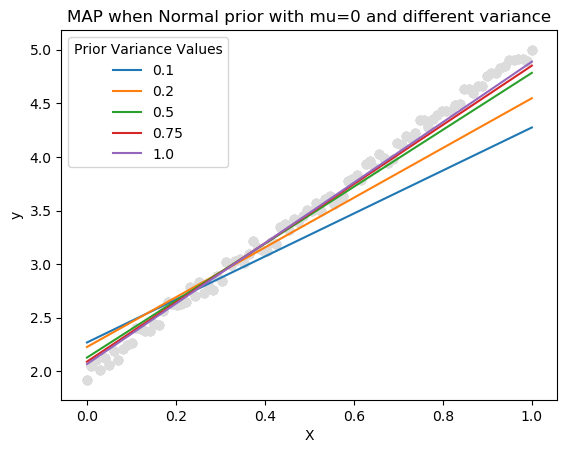

In [123]:
for th in theta_list:
    Xt=X.detach().numpy()
    thetat = th.detach().numpy()


    plt.scatter(Xt,y,c='gainsboro')
    ypoints_map = thetat[1]* Xt + thetat[0]
    
    
    plt.plot(Xt,ypoints_map)
plt.legend(['0.1','0.2','0.5','0.75','1.0'],title = "Prior Variance Values")
plt.xlabel("X")
plt.ylabel("y")
plt.title("MAP when Normal prior with mu=0 and different variance")
plt.show()

### Change the prior to Laplace with mean = 0 and scale = 1. Compare the MAP estimate with the one obtained in (i). What do you observe? [0.5 mark]

In [98]:
def neg_log_prior_laplace(theta):
    prior_mean = torch.tensor([0.0,0.0])  # Prior mean for slope and intercept
    prior_std = torch.tensor(
        [1.0, 1.0]
    )  # Prior standard deviation for slope and intercept
    dist = torch.distributions.laplace.Laplace(prior_mean, prior_std)
    return -dist.log_prob(theta).sum()

def neg_log_joint_laplace(theta):
    return nll(theta) + neg_log_prior_laplace(theta)

n=100
slope = 3
intercept = 2
X = np.linspace(0, 1, n)
noise = np.random.normal(0, 0.05, n)
y = slope * X + intercept + noise

X = torch.tensor(X)
y = torch.tensor(y)

# For Laplace prior
theta_l = torch.tensor([1.0,1.0], requires_grad=True)
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.SGD([theta_l], lr=0.001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = neg_log_joint_laplace(theta_l)
#     print(out,theta)

    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())


# For Normal prior
theta_n = torch.tensor([1.0,1.0], requires_grad=True)
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.SGD([theta_n], lr=0.001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = neg_log_joint(theta_n)
#     print(out,theta)

    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())

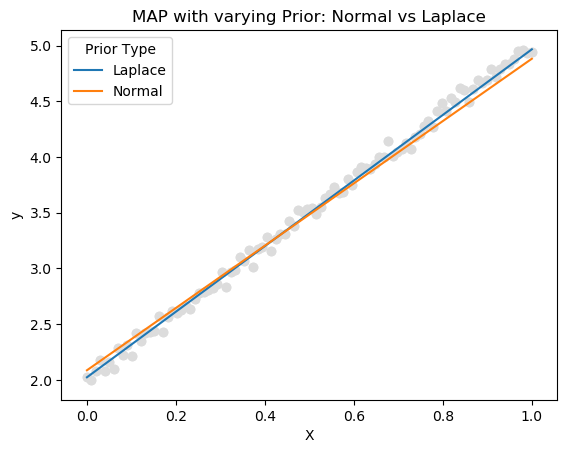

In [100]:
for th in [theta_l,theta_n]:
    Xt=X.detach().numpy()
    thetat = th.detach().numpy()


    plt.scatter(Xt,y,c='gainsboro')
    ypoints_map = thetat[1]* Xt + thetat[0]
    
    
    plt.plot(Xt,ypoints_map)
plt.legend(['Laplace','Normal'],title = "Prior Type")
plt.xlabel("X")
plt.ylabel("y")
plt.title("MAP with varying Prior: Normal vs Laplace")
plt.show()

# Question 4:
### [Total marks: 1.5] Generate a classification dataset with the following code (4.1). 



In [111]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=100, centers=2, n_features=2, random_state=0, cluster_std=0.8
)

X = torch.Tensor(X)
y = torch.Tensor(y)

### Find the MAP estimate for the parameters of logistic regression. Assume Normal prior with mean=0 and variance=0.1 for all parameters. Visualize the MLE and MAP classification boundaries. What do you observe? [1.5 marks]

In [112]:
def nll_lr_logits(theta):
    logits = theta[2]* X[:,1] + theta[1]* X[:,0] + theta[0]
#     print(logits)
    dist = torch.distributions.Bernoulli(logits=logits)
    return -dist.log_prob(y).sum()

def neg_log_prior(theta):
    prior_mean = torch.tensor([0.0, 0.0,0.0])  # Prior mean for slope and intercept
    std = np.sqrt(0.1)
    prior_std = torch.tensor(
        [std,std,std]
    )  # Prior standard deviation for slope and intercept
    dist = torch.distributions.normal.Normal(prior_mean, prior_std)
    return -dist.log_prob(theta).sum()

def neg_log_joint(theta):
    return nll_lr_logits(theta) + neg_log_prior(theta)

In [113]:
theta = torch.tensor([1.0,1.0,1.0], requires_grad=True)
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.SGD([theta], lr=0.0001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = neg_log_joint(theta)
#     print(out,theta)
    
    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())

In [114]:
theta_mle = torch.tensor([1.0,1.0,1.0], requires_grad=True)
# Gradient descent loop
n_epochs = 3000
optimizer = torch.optim.SGD([theta_mle], lr=0.0001)
# out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = nll_lr_logits(theta_mle)
#     print(out,theta_mle)
    
    out.backward()
    optimizer.step()
#     out_list.append(out.detach().numpy())

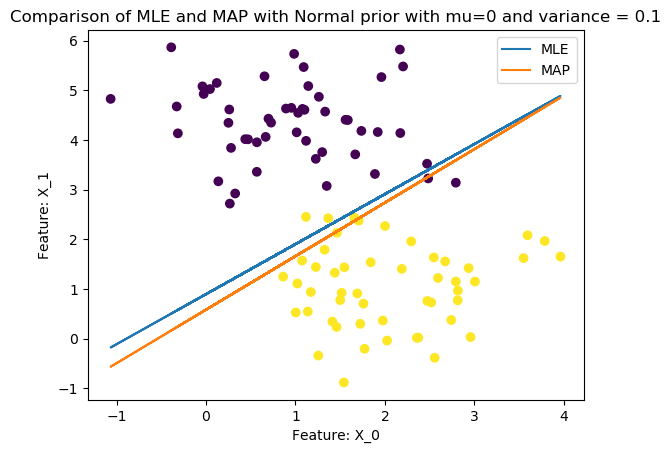

In [115]:
Xt=X.detach().numpy()
theta_mlet = theta_mle.detach().numpy()
thetat = theta.detach().numpy()


plt.scatter(Xt[:,0],Xt[:,1],c=y)
ypoints_mle = (- theta_mlet[1]* Xt[:,0] - theta_mlet[0])/theta_mlet[2]
ypoints_map = (- thetat[1]* Xt[:,0] - thetat[0])/thetat[2]
plt.plot(Xt[:,0],ypoints_mle)
plt.plot(Xt[:,0],ypoints_map)
plt.legend(['MLE','MAP'])
plt.xlabel("Feature: X_0")
plt.ylabel("Feature: X_1")
plt.title("Comparison of MLE and MAP with Normal prior with mu=0 and variance = 0.1")
plt.show()